In [91]:
import cv2
from PIL import Image 

def to_pil(cv_img):
    img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)
import numpy as np

In [75]:
def generate_anchors(base_size=16, ratios=None, scales=None):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales w.r.t. a reference window.
    """

    if ratios is None:
        ratios = np.array([0.5, 1, 2])

    if scales is None:
        scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

    num_anchors = len(ratios) * len(scales)

    # initialize output anchors
    anchors = np.zeros((num_anchors, 4))

    # scale base_size
    anchors[:, 2:] = base_size * np.tile(scales, (2, len(ratios))).T

    # compute areas of anchors
    areas = anchors[:, 2] * anchors[:, 3]

    # correct for ratios
    anchors[:, 2] = np.sqrt(areas / np.repeat(ratios, len(scales)))
    anchors[:, 3] = anchors[:, 2] * np.repeat(ratios, len(scales))

    # transform from (x_ctr, y_ctr, w, h) -> (x1, y1, x2, y2)
    anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
    anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T

    return anchors

def shift(shape, stride, anchors):
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    shifts = np.vstack((
        shift_x.ravel(), shift_y.ravel(),
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    A = anchors.shape[0]
    K = shifts.shape[0]
    all_anchors = (anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
    all_anchors = all_anchors.reshape((K * A, 4))

    return all_anchors


In [84]:
image_shape = (360,640)
image_shape = np.array(image_shape)
image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in pyramid_levels]

In [85]:
pyramid_levels = [3, 4, 5, 6, 7]
sizes = [2 ** (x + 2) for x in pyramid_levels]
ratios = np.array([0.5, 1, 2])
scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])
strides = [2 ** x for x in pyramid_levels]

In [86]:
for idx, p in enumerate(pyramid_levels):
    anchors         = generate_anchors(base_size=sizes[idx], ratios=ratios, scales=scales)
    shifted_anchors = shift(image_shapes[idx], strides[idx], anchors)
    all_anchors     = np.append(all_anchors, shifted_anchors, axis=0)

all_anchors = np.expand_dims(all_anchors, axis=0)

In [105]:
img = np.zeros((360,640,3)).astype(np.uint8)

In [108]:
for bbox in all_anchors[0][9*1000:9*1000+18]:
    x1, y1, x2, y2 = bbox
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,255), 1)
#     break

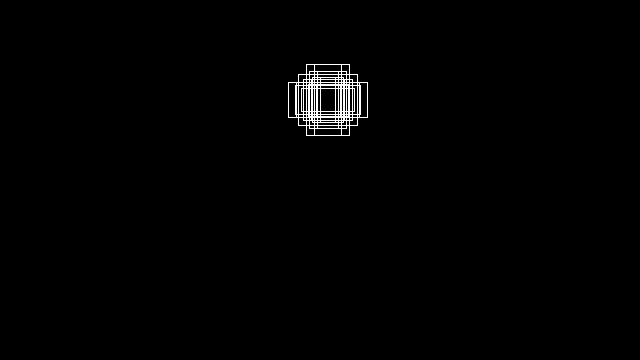

In [109]:
to_pil(img)

In [46]:
shape = image_shapes[0]
stride = strides[0]
shift_x = (np.arange(0, shape[1]) + 0.5) * stride
shift_y = (np.arange(0, shape[0]) + 0.5) * stride

In [50]:
np.meshgrid([1,2], [2,3])

[array([[1, 2],
        [1, 2]]), array([[2, 2],
        [3, 3]])]

In [52]:
shift_x, shift_y = np.meshgrid(shift_x, shift_y)

In [56]:
shifts = np.vstack((
    shift_x.ravel(), shift_y.ravel(),
    shift_x.ravel(), shift_y.ravel()
)).transpose()

In [59]:
A = anchors.shape[0]
K = shifts.shape[0]

In [68]:
anchors.reshape((1, A, 4))

array([[[-5.65685425, -2.82842712,  5.65685425,  2.82842712],
        [-7.12718975, -3.56359487,  7.12718975,  3.56359487],
        [-8.97969639, -4.48984819,  8.97969639,  4.48984819],
        [-4.        , -4.        ,  4.        ,  4.        ],
        [-5.0396842 , -5.0396842 ,  5.0396842 ,  5.0396842 ],
        [-6.34960421, -6.34960421,  6.34960421,  6.34960421],
        [-2.82842712, -5.65685425,  2.82842712,  5.65685425],
        [-3.56359487, -7.12718975,  3.56359487,  7.12718975],
        [-4.48984819, -8.97969639,  4.48984819,  8.97969639]]])

In [69]:
shifts.reshape((1, K, 4)).shape

(1, 3600, 4)

In [66]:
shifts.reshape((1, K, 4)).transpose((1, 0, 2))

array([[[  4.,   4.,   4.,   4.]],

       [[ 12.,   4.,  12.,   4.]],

       [[ 20.,   4.,  20.,   4.]],

       ...,

       [[620., 356., 620., 356.]],

       [[628., 356., 628., 356.]],

       [[636., 356., 636., 356.]]])

In [70]:
all_anchors = (anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2)))

In [74]:
all_anchors.reshape((K * A, 4)).shape

(32400, 4)

In [ ]:

# add A anchors (1, A, 4) to
# cell K shifts (K, 1, 4) to get
# shift anchors (K, A, 4)
# reshape to (K*A, 4) shifted anchors


all_anchors = all_anchors.reshape((K * A, 4))
